In [1]:
import numpy as np
#import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sla
import numpy.linalg as la
import sys, os
import pickle
import shapefile
#import rbf as RBF
import warnings
os.environ["CHOLMOD_USE_GPU"] = "1"
warnings.filterwarnings('ignore')
#%matplotlib inline
sys.path.insert(0, os.environ['FaultSRC']) #add src folder to path for notebook
%load_ext snakeviz
%load_ext cython

In [2]:
from FME import *

In [3]:
shpdir = '/home/lgrose/dev/python/faults/case_studies/faulted_fold/shapefiles/'
orientations = shapefile.Reader(shpdir+'orientations.shp').shapeRecords()
lines = shapefile.Reader(shpdir+'lines.shp').shapeRecords()
points = shapefile.Reader(shpdir+'points.shp').shapeRecords()
def reload_data():
    global shpdir
    global orientations
    global lines
    global points
    shpdir = '/home/lgrose/dev/python/faults/case_studies/faulted_fold/shapefiles/'
    orientations = shapefile.Reader(shpdir+'orientations.shp').shapeRecords()
    lines = shapefile.Reader(shpdir+'lines.shp').shapeRecords()
    points = shapefile.Reader(shpdir+'points.shp').shapeRecords()
reload_data()
# fault_dip = shapefile.Reader(shpdir+'fault_dip.shp').shapeRecords()
# fault_points = shapefile.Reader(shpdir+'points.shp').shapeRecords()
# fault_trace = shapefile.Reader(shpdir+'fault_trace.shp').shapeRecords()
#First mesh is for the interpolation support and should be larger than the model area
model_area = shapefile.Reader(shpdir+'big_box.shp')
geom = model_area.shapes()
coords = np.array(geom[0].points)
minz = -(np.max(coords[:,0])-np.min(coords[:,0]))/2.

In [4]:
boundary_points = np.zeros((2,3))
boundary_points[0,0] = np.min(coords[:,0])
boundary_points[0,1] = np.min(coords[:,1])
boundary_points[0,2] = minz
boundary_points[1,0] = np.max(coords[:,0])
boundary_points[1,1] = np.max(coords[:,1])
boundary_points[1,2] = -minz*0.1
mesh = TetMesh('FaultedFold',)
mesh.setup_mesh(boundary_points,nstep=1,n_tetra=100000,)
regionmanager = RegionManager(mesh)
xrange = boundary_points[1,0] - boundary_points[0,0]
yrange = boundary_points[1,1] - boundary_points[0,1]
zrange = boundary_points[1,2] - boundary_points[0,2]
r1 = np.array(boundary_points,copy=True)
r1[0,0] += xrange*.05
r1[1,0] -= xrange*.05
r1[0,1] += yrange*.05
r1[1,1] -= yrange*.05
r1[0,2] += zrange*.05
r1[1,2] -= zrange*.05

regionmanager.create_region_from_boundary_box(r1,'r1')

#mesh.regions['R1'] = np.logical_and(mesh.nodes[:,0]>boundary_points[0,0]*.8,mesh.nodes[:,0]<boundary_points[1,0]*.8)
# mesh.regions['R1']= np.logical_and(mesh.regions['R1'],mesh.nodes[:,1]>boundary_points[0,1]*.8) #ymin
# mesh.regions['R1']= np.logical_and(mesh.regions['R1'],mesh.nodes[:,1]<boundary_points[1,1]*.8)
# mesh.regions['R1']= np.logical_and(mesh.regions['R1'],mesh.nodes[:,2]>boundary_points[0,2]*.8)
# mesh.regions['R1']= np.logical_and(mesh.regions['R1'],mesh.nodes[:,2]<boundary_points[1,2]*.8)
#print(mesh.regions['R1'])
#regionmanager.create_region_from_boundary_box(boundary_points*.8,'r1')
regionmanager.create_properties_for_regions()
cg = mesh.get_constant_gradient(region=mesh.regions['everywhere'],shape='square')
# # second mesh is for the model area and the points can be moved around. No interpolation \
# # is performed on this mesh its just here because paraview can contour mesh objects not voxets
# boundary_points2 = np.zeros((2,3))
# boundary_points2=boundary_points*0.6
# mesh2 = TetMesh('Flower3DModel')
# mesh2.setup_mesh(boundary_points2,maxvol=0.5)
mesh.save()

In [9]:
reload_data()
f2 = FoldFrame(mesh=mesh,region='everywhere',shape='square',name='F1')
for l in lines:
    if l.record[0] == 's1':
        for p in l.shape.points:
            f2.add_point([p[0],p[1],0],0,itype='gx')
for o in orientations:
    if o.record[0] == 's1':
        p = o.shape.points[0]
        f2.add_strike_and_dip([p[0],p[1],0.],o.record[1],o.record[2],itype=o.record[3])
for p in points:
    if p.record[1]  == 's1':
        f2.add_point([p.shape.points[0][0],p.shape.points[0][1],p.record[3]],float(p.record[0]),itype=p.record[2])
f2.buildFrame(solver='lu')
f2.interpolators['gx'].export_data_to_vtk('fold_f2_gx_data')

# s2.setup_interpolator()
# s2.solve_system(solver='chol')
# mesh.update_property('s2',s2.c)

Setting up interpolator with 2 value control points 
        0 gradient control points and 0 tangent control points and 
        constant gradient regularization with a weight of 0.100000
Setting up interpolator with 2 value control points 
        0 gradient control points and 0 tangent control points and 
        constant gradient regularization with a weight of 0.100000


In [10]:
def fold_axis_rotation(x):
    r =  np.zeros(x.shape)
    r[:] = 0.
    return r#np.rad2deg(np.arctan(np.sin(x*100)))
def fold_limb_rotation(x):
    return np.rad2deg(np.arctan(np.sin(x*2)))

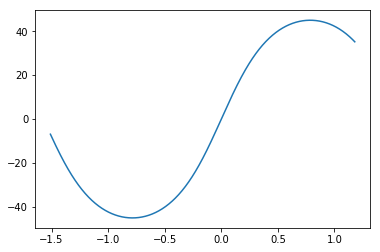

In [11]:
xi = np.linspace(np.min(mesh.properties['F1_gx']),np.max(mesh.properties['F1_gx']),1000)
plt.plot(xi,fold_limb_rotation(xi))
#plt.plot(s2,rotation,'bo')

In [12]:
fold = FoldEvent(f2,fold_axis_rotation,fold_limb_rotation)
const = DSIFoldConstraint(fold,mesh,shape='square')
const.use_deformed_orientation_cnstrt(5.)
const.use_fold_axis_cnstrt(3.)
const.use_regularisation_cnstrt(10.)
const.use_normalisation_cnstrt()

A, B, row, col = const.get_constraints()
deformed_orientation, fold_axis, dgz = fold.get_deformed_orientation(mesh.barycentre)
mesh.property_gradients['fold'] = deformed_orientation
mesh.property_gradients['axis'] = fold_axis
mesh.update_property('foldrot',fold_limb_rotation(mesh.properties['F1_gx']))

In [19]:
reload_data()
gx=True
gy=True
gz=True
cgw = 100
cgw = cgw / mesh.n_elements
fault1 = FaultSegment(mesh=mesh,region='everywhere',shape='square',name='Fault1')
# for l in lines:
#     if l.record[0] == 'f1':
#         for p in l.shape.points:
#             fault1.add_point([p[0],p[1],0],0,itype='gx')
for o in orientations:
    print(o.record)
    if o.record[0] == 'f1':
        p = o.shape.points[0]
        fault1.add_strike_and_dip([p[0],p[1],0.],o.record[1],o.record[2],itype=o.record[3])
for p in points:
    print(p.record)
    if p.record[1]  == 'f1':
        fault1.add_point([p.shape.points[0][0],p.shape.points[0][1],p.record[3]],float(p.record[0]),itype=p.record[2])

fault1.interpolators['gx'].add_fold_constraints(A,B,col,row)
fault1.buildFrame(solver='chol',
                   gxxgy=cgw,
                   gxxgz=cgw,
                   gyxgz=cgw,
                   gxcg=0,
                   gycg=0,
                   gzcg=0,
                   shape='square',
                   gxgcp=10,
                   gx=gx,
                   gy=True,
                   gz=True
                  )
fault1.interpolators['gy'].export_data_to_vtk('fault_f1_gy_data')
fault1.interpolators['gz'].export_data_to_vtk('fault_f1_gz_data')
fault1.interpolators['gx'].export_data_to_vtk('fault_f1_gx_data')

Record #0: [-1.0, 's1', 'gx', 0.0]
Record #1: [1.0, 's1', 'gx', 0.0]
Record #2: [-1.0, 's1', 'gy', 0.0]
Record #3: [1.0, 's1', 'gy', 0.0]
Record #4: [-1.0, 'f1', 'gy', 0.0]
Record #5: [1.0, 'f1', 'gy', -10.0]
Record #6: [-1.0, 'f1', 'gz', 0.0]
Record #7: [1.0, 'f1', 'gz', 0.0]
Setting up interpolator with 0 value control points 
        0 gradient control points and 0 tangent control points and 
        constant gradient regularization with a weight of 0.000000


CholmodNotPositiveDefiniteError: ../Supernodal/t_cholmod_super_numeric.c:911: matrix not positive definite (code 1)

In [19]:
stratigraphy = DSI(mesh,region='everywhere',shape='square',solver='chol')
# for i in range(-15,15):
#     for j in range(-10,10):
#         stratigraphy.add_point([i,j,3*np.sin(j/5)],0.)
#         stratigraphy.add_point([i,j,3*np.sin(j/5)+1],1.)
stratigraphy.add_point([70.1,0.1,1.1],0.)
# stratigraphy.add_point([80.1,0.1,1.1],1.)


stratigraphy.setup_interpolator(cg=False,cgw=0.)
stratigraphy.A.extend(A)
stratigraphy.row.extend(row)
stratigraphy.col.extend(col)
stratigraphy.B+=B
stratigraphy.solve_system(solver='lu',clear=True)
mesh.update_property('strati',stratigraphy.c)

Setting up interpolator with 1 value control points 
        0 gradient control points and 0 tangent control points and 
        constant gradient regularization with a weight of 0.000000


In [26]:
d=zrange*0.2
gxl = 240
gzl = 2
fault1.buildFaultDisplacementField(
    dm=d
)
newpoints = np.array(mesh.nodes[mesh.regions['r1']],copy=True, order='C')
newpoints  = fault1.applyFault(newpoints,region='r1',steps=10,boundary_pointssteps=40)
np.savetxt('fault1movedpoints.txt',newpoints,delimiter=',')



In [27]:

interp = np.zeros(mesh.properties['strati'].shape)
interp[:] = np.nan
interp[mesh.regions['r1']] = mesh.eval_interpolant(newpoints,'strati',k=50)
mesh.update_property('strati_int',interp)

In [30]:
import vista
strati = plt.cm.get_cmap('viridis',5)
scalarfield = plt.cm.get_cmap('viridis')
def plot_mesh(mesh,propertyname,cmap):
    vmesh = vista.read(mesh.path+mesh.name+'.vtk')
    p = vista.Plotter(notebook=True)
    p.set_background('white')
    p.add_mesh(
        vmesh,
        cmap=cmap,
        show_scalar_bar=False,
        nan_opacity=0.,
        scalars=mesh.properties[propertyname],
        interpolate_before_map=True
    )
    p.show()

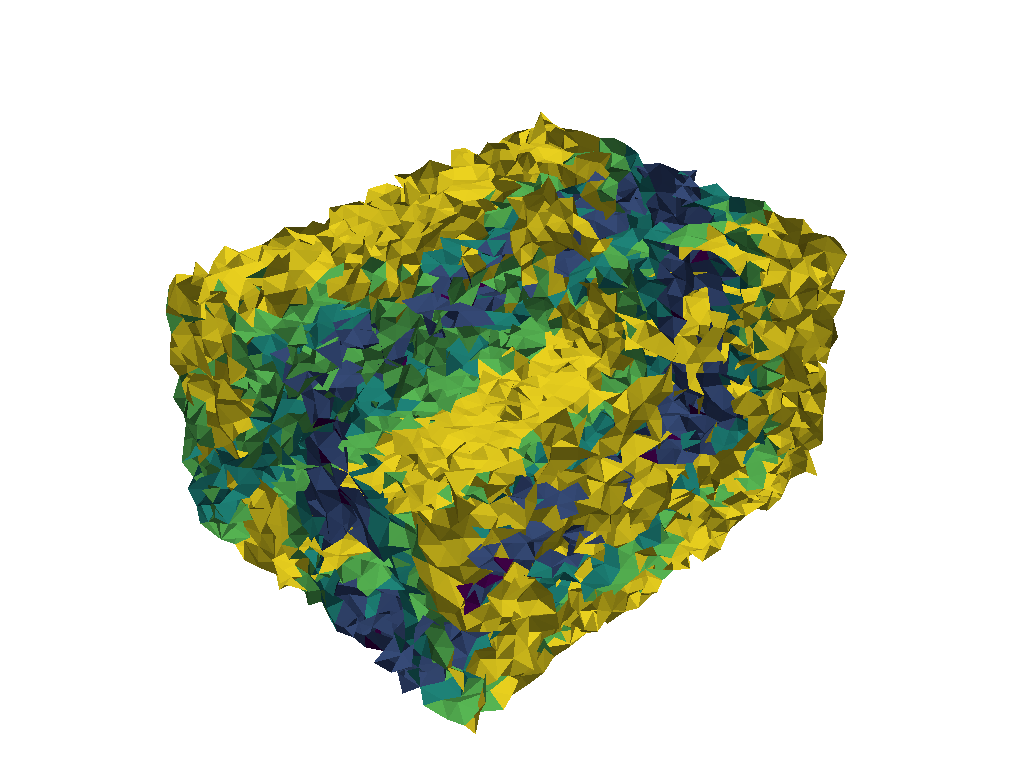

In [48]:
cmap=strati
propertyname = 'strati'
vmesh = vista.read(mesh.path+mesh.name+'.vtk')
vmesh.set_active_scalar(propertyname)
slices = vmesh.slice_orthogonal()
vmesh.set_active_scalar('REGION_r1')
cl
thresh = vmesh.threshold([0.5,1])
thresh.set_active_scalar(propertyname)
p = vista.Plotter(notebook=True)
p.set_background('white')
p.add_mesh(
    thresh,
    cmap=cmap,
    show_scalar_bar=False,
    nan_opacity=0.,
    #scalars=mesh.properties[propertyname],
    interpolate_before_map=True
)
# #p.slice()
p.show()
    #vista
#plot_mesh(mesh,'strati_int',strati)